## Module 6:  Twitter Dataset for Trustworthiness

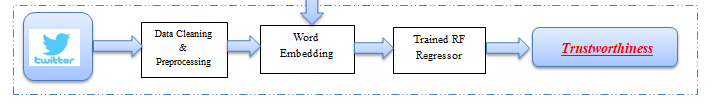

In [1]:
from PIL import Image
Image.open("arc_4.png")

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
#http://rasbt.github.io/mlxtend/
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import warnings 
warnings.filterwarnings("ignore")

import glob
from bs4  import  BeautifulSoup
from nltk.corpus import wordnet as wn

## 1. Loading the data

### 1.1 Merging the data files 

In [74]:
anger_data = pd.read_csv("data/twitter/anger-ratings.txt" ,delimiter = "\t", error_bad_lines=False ,header=None)
fear_data = pd.read_csv("data/twitter/fear-ratings.txt" ,delimiter = "\t", error_bad_lines=False ,header=None)
joy_data = pd.read_csv("data/twitter/joy-ratings.txt" ,delimiter = "\t", error_bad_lines=False ,header=None)
sadness_data = pd.read_csv("data/twitter/sadness-ratings.txt" ,delimiter = "\t", error_bad_lines=False ,header=None)

In [75]:
#https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames = [anger_data, fear_data, joy_data , sadness_data]
twitter_data = pd.concat(frames)

In [76]:
twitter_data.head(10)

,0,1,2,3
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896
5,10005,My blood is boiling,anger,0.875
6,10006,When you've still got a whole season of Wentwo...,anger,0.875
7,10007,@bt_uk why does tracking show my equipment del...,anger,0.875
8,10008,@TeamShanny legit why i am so furious with him...,anger,0.875
9,10009,How is it suppose to work if you do that? Wtf ...,anger,0.875


### 1.2 Shuffling the data 

In [77]:
#https://www.geeksforgeeks.org/pandas-how-to-shuffle-a-dataframe-rows/?ref=rp
# shuffle the DataFrame rows 
twitter_data = twitter_data.sample(frac = 1) 
twitter_data.head(10)

,0,1,2,3
544,30544,@veggiesausage that happens...u will be ok tom...,joy,0.396
163,20163,Don't wanna really go out but I can't say no. ...,fear,0.708
232,10232,@xxmariab listen yh don't provoke me cos I'll ...,anger,0.604
319,20319,"However the agent was inauthentic, my sister s...",fear,0.604
1228,21228,Northampton are awful ðŸ™ˆ,fear,NONE
2148,22184,The Pats are awesome. Belichick is awesome ......,fear,NONE
1424,21460,@yonahimes they never posted stuff like this??...,fear,NONE
1306,21196,@CNNPolitics I can't wait to hear what he had ...,fear,0.354
5,10005,My blood is boiling,anger,0.875
333,30333,"her fingers slide along your thighs, caressing...",joy,0.540


In [78]:
twitter_data.shape

(7303, 4)

### 1.3 Loading the test data

In [79]:
twitter_test = twitter_data[1]

In [80]:
twitter_test

544     @veggiesausage that happens...u will be ok tom...
163     Don't wanna really go out but I can't say no. ...
232     @xxmariab listen yh don't provoke me cos I'll ...
319     However the agent was inauthentic, my sister s...
1228                           Northampton are awful ðŸ™ˆ
                              ...                        
571     @patthemanager how could I work with @chanceth...
1099    @WellerMonica Hi Monica, I write regularly for...
636     On the bright side with YouTube heroes leafy w...
431     @NeyaphemMaster @_James_Kellar_ @RavenMetamorp...
799     @kayleighmcenany  @DonaldJTrumpJr Is that real...
Name: 1, Length: 7303, dtype: object

In [81]:
type(twitter_test)

pandas.core.series.Series

## 2.Preprocessing 

In [82]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase  = re.sub('[^A-Za-z]+', ' ', phrase )
    phrase = re.sub(r"won't", "will not", phrase)      # replace won't with "will not"
    phrase = re.sub(r"can\'t", "can not", phrase)      # replace can or cant with 'can not'
    phrase = re.sub(r"n\'t", " not", phrase)           # replece n with 'not'
    phrase = re.sub(r"\'re", " are", phrase)           # replace re with 'are'
    phrase = re.sub(r"\'s", " is", phrase)             # replace s with 'is'
    phrase = re.sub(r"\'d", " would", phrase)          # replace 'd' with 'would'
    phrase = re.sub(r"\'ll", " will", phrase)          # replace 'll with 'will'
    phrase = re.sub(r"\'t", " not", phrase)            # replace 't' with 'not'
    phrase = re.sub(r"\'ve", " have", phrase)          # replace ve with 'have'
    phrase = re.sub(r"\'m", " am", phrase)             # replace 'm with 'am'
    return phrase

In [83]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
#print(stopwords)
len(stopwords)

179

In [84]:
# Combining all the above stundents 
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from collections import Counter 

p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text_data):
    preprocessed_text = []             
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)           #calling funcion for each sentence
        #print("1st sent" , sent)
        sent = sent.replace('\\r', ' ')         # replace line terminator with space
        sent = sent.replace('\\n', ' ')         # replace new line charactor with space
        sent = sent.replace('\\"', ' ')         
        sent = re.sub('[^A-Za-z]+', ' ', sent)  # remove anything that is not letter
        sent = ''.join(p_stemmer.stem(token) for token in sent )
        sent = ''.join(lemmatizer.lemmatize(token) for token in sent )
        sent  = ' '.join(e for e in sent.split() if len( Counter(e)) > 2 )
        #sent = lstr(emmatize_text(sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords ) # checking for stop words
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [85]:
twitter_x = preprocess_text(twitter_test.apply(str))

100%|██████████| 7303/7303 [00:05<00:00, 1278.49it/s]


In [86]:
twitter_x

['veggiesausage happens tomorrow cheer give',
 'wanna really say deffo fear missing',
 'xxmariab listen provoke cos make cry',
 'however agent inauthentic sister still loves amp still alive guess bad socialanxiety anxiety',
 'northampton awful',
 'pats awesome belichick awesome awestruck',
 'yonahimes never posted stuff like mean able scroll wasnt big deal',
 'cnnpolitics wait hear say brilliant hawking rich poorest taste bully',
 'blood boiling',
 'fingers slide along thighs caressing skin leaning first lick teasing playful',
 'davuuwart hilarious',
 'expressscripts shd embrrssd jack meds twice still take days express expressscripts horrible',
 'somewhere hope despair day meetingmyabuserincourt dvsurvivor',
 'join btcare put phone talk rude taking money willynilly',
 'educate child rich educate happy grow know value things price',
 'yahweh god among warrior saves rejoice gladness',
 'maddenfreestyle turn game wanting play madden load game turn',
 'rewatching raising hope hubs time tot

In [87]:
from sklearn.externals import joblib
clf = joblib.load("saved_model/RF_regressor_model_.pkl")  # loading the enseble classifier model from isear data 
vectorizer_sit = joblib.load('saved_model/vectorizer_sit.pkl')

In [88]:
vec_twitter = vectorizer_sit.transform(twitter_x).toarray()

In [89]:
vec_twitter.shape

(7303, 6450)

## 3. Vector Transformation : Word Embedding

In [90]:
import pickle
with open('output_files/feature_dict', 'rb') as f:              # Opening feature_dict file for recreating input matrix 
    feature_dict = pickle.load(f)

In [91]:
with open('output_files/features', 'rb') as f:              # Opening feature file for recreating input matrix
    new_features = pickle.load(f)

In [92]:
feature_dict

{'abandoned': 0.029018751640941313,
 'abdomen': 0.029018751640941313,
 'abdominal': 0.029018751640941313,
 'abide': 0.029018751640941313,
 'abilities': 0.029018751640941313,
 'ability': 0.029018751640941313,
 'ablation': 0.04562392619103551,
 'able': 0.0,
 'abnormal': 0.0,
 'aboout': 0.022454986388823636,
 'aboriginal': 0.029018751640941313,
 'abortion': 0.029018751640941313,
 'aborts': 0.029018751640941313,
 'abou': 0.0,
 'abour': 0.0,
 'aboutthe': 0.013781603953920064,
 'abroad': 0.0,
 'abrupt': 0.0,
 'abruptly': 0.0,
 'abscence': 0.028719351822423664,
 'absence': 0.056604990304052034,
 'absent': 0.029018751640941313,
 'absolutely': 0.0,
 'abuse': 0.04562392619103551,
 'abused': 0.029018751640941313,
 'abusing': 0.029018751640941313,
 'abusive': 0.0,
 'abut': 0.029018751640941313,
 'academic': 0.029018751640941313,
 'academically': 0.0,
 'academics': 0.029018751640941313,
 'acccident': 0.0,
 'acccused': 0.0,
 'accelerating': 0.019212256046724795,
 'accent': 0.029018751640941313,
 'ac

In [93]:
new_twitter_train = np.zeros((vec_twitter.shape[0],vec_twitter.shape[1]))

for row in range(len(vec_twitter)):
    for col in range(len(vec_twitter[row])):
        if vec_twitter[row][col] != 0.0:
            #print(X_test[row][col],"==>",col)
            val = feature_dict[new_features[col]]
            new_twitter_train[row][col] = val 

In [94]:
new_twitter_train.shape

(7303, 6450)

## 4. Applying train Random Forest Regressor Model

In [95]:
y_pred_twitter = clf.predict(new_twitter_train)

In [96]:
y_pred_twitter , type(y_pred_twitter)

(array([0., 0., 0., ..., 0., 0., 0.]), numpy.ndarray)

In [97]:
len(y_pred_twitter)

7303

In [98]:
# Creating DataFrame of Predicted Output
pred_df = pd.DataFrame(columns=["Predicted_label"])
t_count = 0
n_count = 0

for r in range(len(y_pred_twitter)):
    if y_pred_twitter[r] !=0 :
        pred_df.loc[r] = ['Trustworthy']
        t_count +=1
    else :
        pred_df.loc[r] = ['Not Trustworthy']
        n_count +=1

In [99]:
t_count , n_count

(735, 6568)

In [100]:
merged_output = pd.concat([pd.DataFrame(twitter_x), pred_df ],ignore_index=True, sort=False , axis =1)
merged_output.columns = ["Tweet" , "Predicted_Label"]

### Resultant DataFrame

In [101]:
merged_output.head(10)

,Tweet,Predicted_Label
0,veggiesausage happens tomorrow cheer give,Not Trustworthy
1,wanna really say deffo fear missing,Not Trustworthy
2,xxmariab listen provoke cos make cry,Not Trustworthy
3,however agent inauthentic sister still loves a...,Not Trustworthy
4,northampton awful,Not Trustworthy
5,pats awesome belichick awesome awestruck,Not Trustworthy
6,yonahimes never posted stuff like mean able sc...,Not Trustworthy
7,cnnpolitics wait hear say brilliant hawking ri...,Trustworthy
8,blood boiling,Not Trustworthy
9,fingers slide along thighs caressing skin lean...,Not Trustworthy


### 4.1 sample twitter 1:Trustworthiness Retrieved 

In [102]:
# sample 1 
sample_tweet = [twitter_x[1795]]
print("\n sample headline :",sample_tweet)

preprocessed_txt = vectorizer_sit.transform(sample_tweet).toarray()
print("Shape of matrix data after one hot encoding : ",preprocessed_txt.shape)
y_predicted = clf.predict(preprocessed_txt)
if y_predicted !=0.0 :
    print("Predicted label : Trustworthy")
else:
    print("Predicted label : Not Trustworthy")
    


 sample headline : ['god knows things happen sometimes hard understand prayingforyou']
Shape of matrix data after one hot encoding :  (1, 6450)
Predicted label : Not Trustworthy


### 4.2 sample twitter 2:Trustworthiness Retrieved 

In [103]:
# sample 2 
sample_tweet = [twitter_x[89]]
print("\n sample headline :",sample_tweet)

preprocessed_txt = vectorizer_sit.transform(sample_tweet).toarray()
print("Shape of matrix data after one hot encoding : ",preprocessed_txt.shape)
y_predicted = clf.predict(preprocessed_txt)
#print(y_predicted)
if y_predicted != 0.0:
    print("Predicted label : Trustworthy")
else:
    print("Predicted label : Not Trustworthy")
    


 sample headline : ['annafifield washingtonpost hands deck post trump starts lead fla']
Shape of matrix data after one hot encoding :  (1, 6450)
Predicted label : Trustworthy
